# HapDAF

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

# from scipy.stats import zscore
import scipy.stats

# from ChromosomeWindows import window
from chromwindow import window

import genominterv

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import mpld3
import seaborn as sns

sns.set_palette('colorblind')
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Local code in the scripts dir on the cluster:

In [4]:
import analysis_globals as ag

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

In [6]:
chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# HapDAF

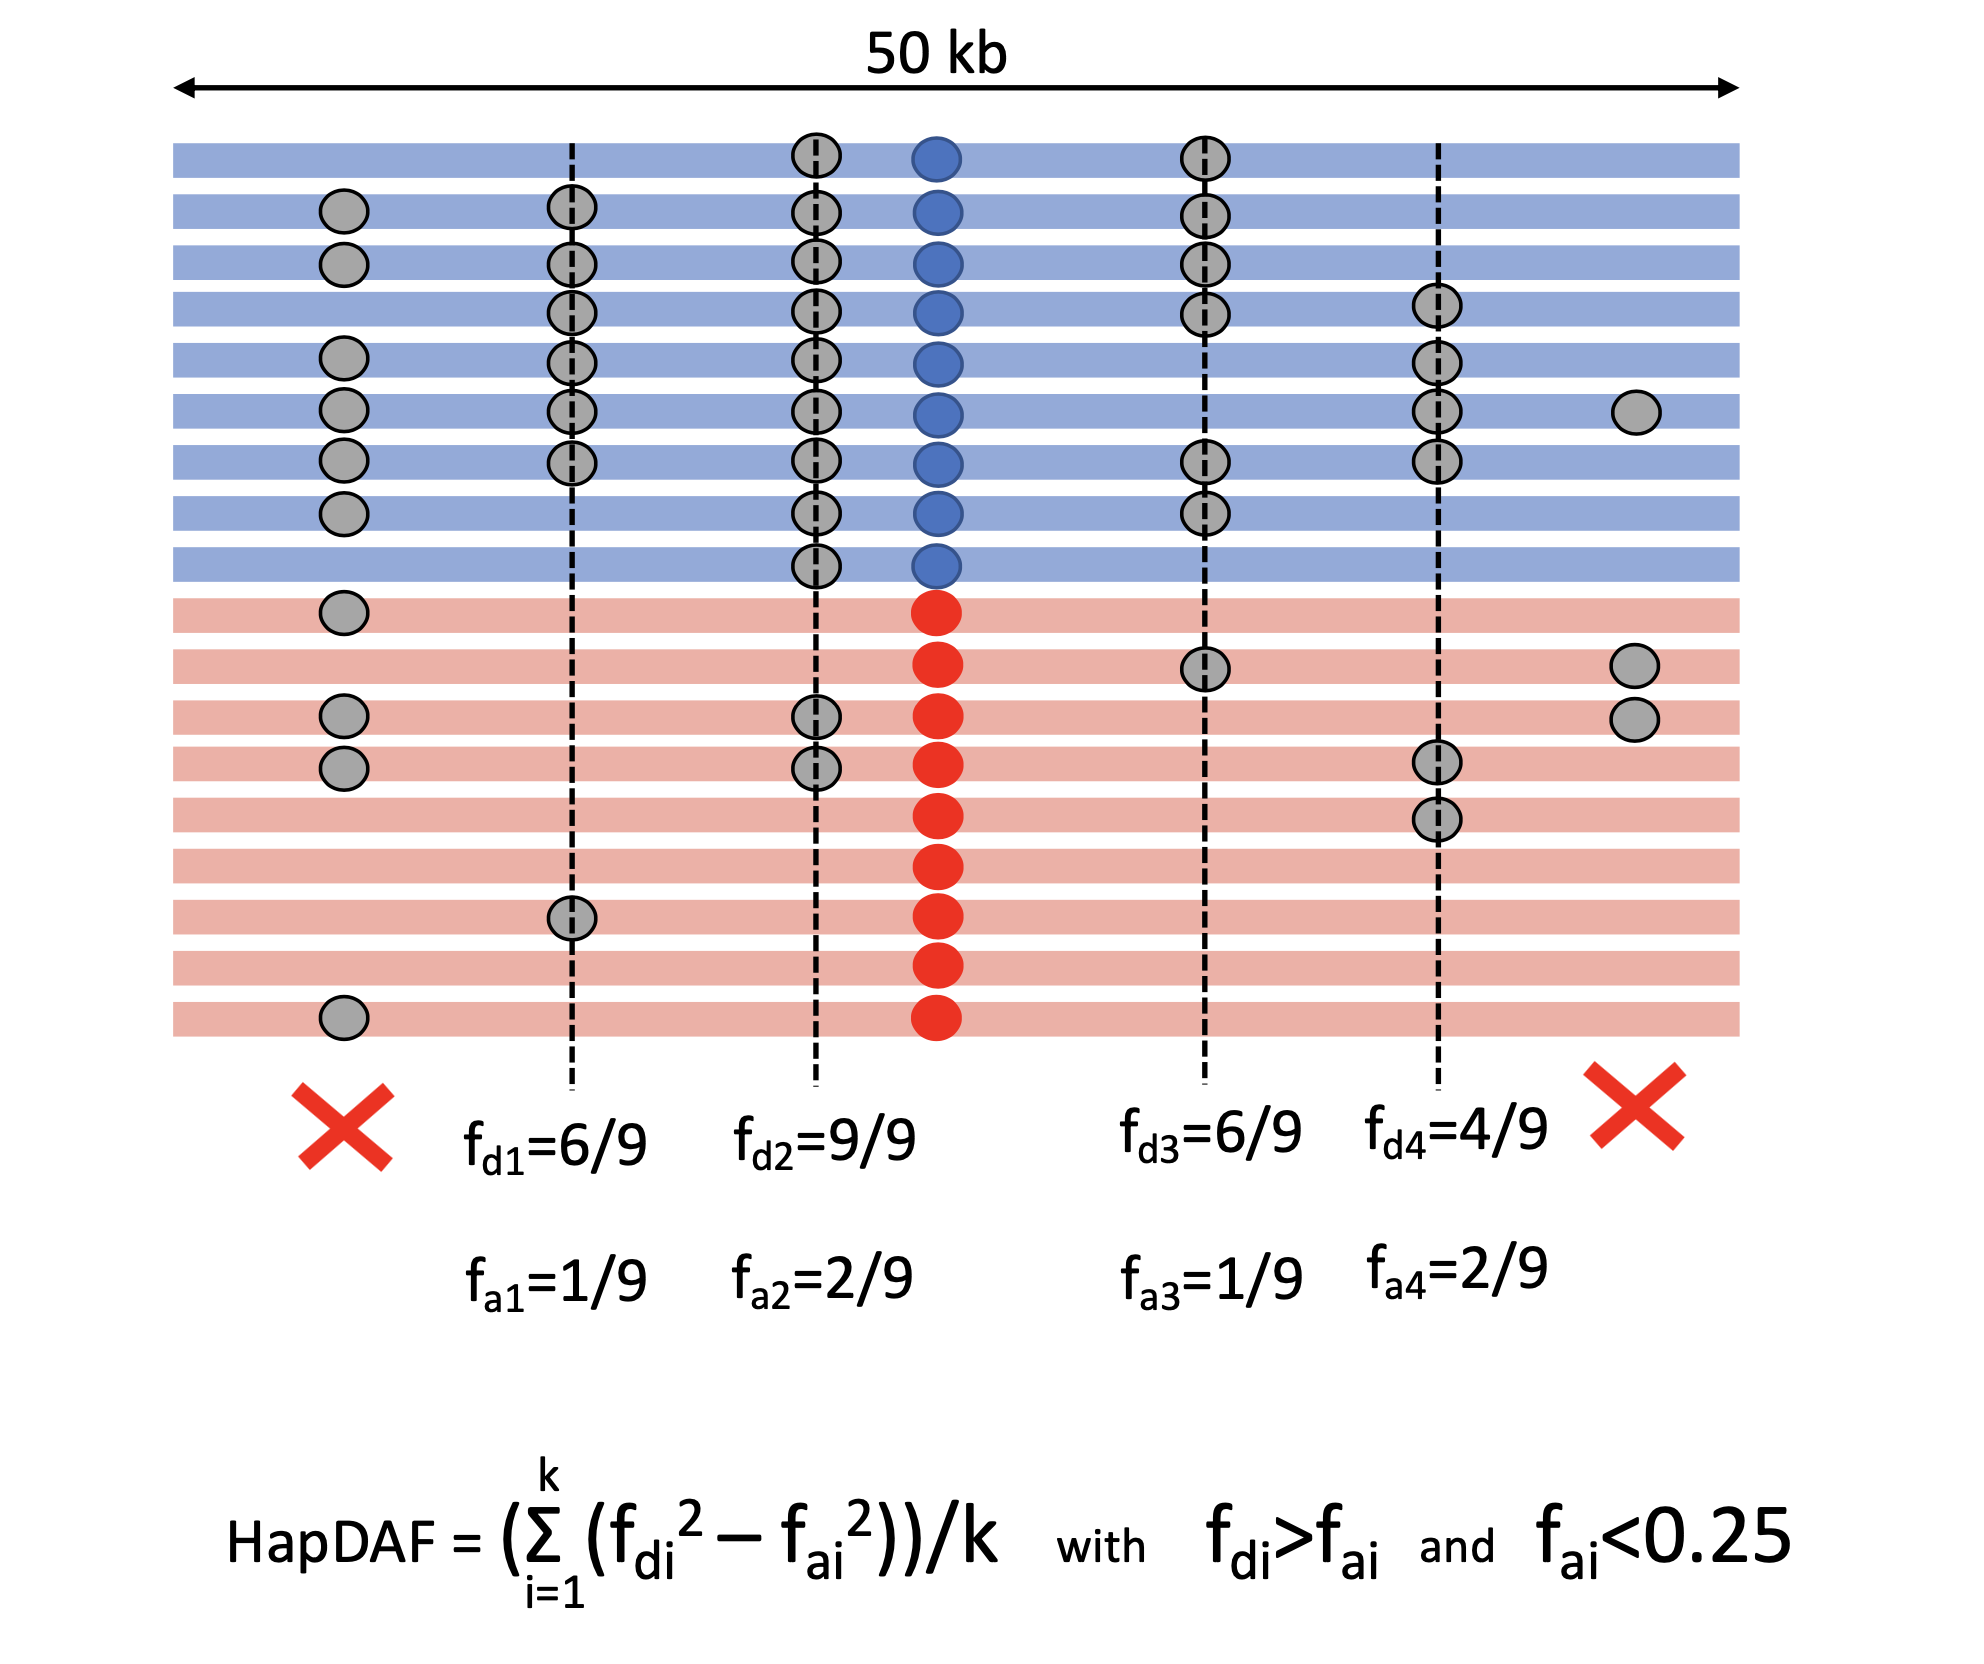

In [7]:
from IPython.display import Image
Image("img/hapdaf.png", width=800)

- The squaring is to make it more sensitive to particularly high frequencies (in the spirit of Fay & Wu's H)

- Only use $f_{di}>f_{ai}$. If not true, it is unlikely that $f_{di}$ increased due to a sweep in the first place.

- For $f_{ai}$ the idea is that if derived allele is at a high frequency on the ancestral background, then there will not be much space to see an increase due to a sweep on the ancestral background.

## Load data

In [8]:
df_list = list()
for chrom in chromosome_lengths.keys():
    try:
        df = pd.read_table(f'/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_50000_{chrom}.txt', 
                      sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf_raw', 'deriv_freq', 'nr_snps'])
    except FileNotFoundError:
        print(f'File for chrom {chrom} not found')
        continue
    df['chrom'] = chrom
    df_list.append(df)
hapdaf_phys = pd.concat(df_list)

File for chrom Y not found


## Standarize hapdaf values

Standardize scores in each frequency bin:

In [9]:
hapdaf_phys['bin'] = hapdaf_phys.deriv_freq // 0.05
hapdaf_phys['is_autosome'] = hapdaf_phys.chrom != 'X'

Pool all chromosomes in standardization:

In [10]:
hapdaf_phys['hapdaf'] = hapdaf_phys.groupby('bin').hapdaf_raw.transform(scipy.stats.zscore)

Standardize autosomes and X chromosome separately:

In [11]:
#hapdaf_phys['hapdaf'] = hapdaf_phys.groupby(['bin', 'is_autosome']).hapdaf_raw.transform(zscore)

Plot standardized values:

/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


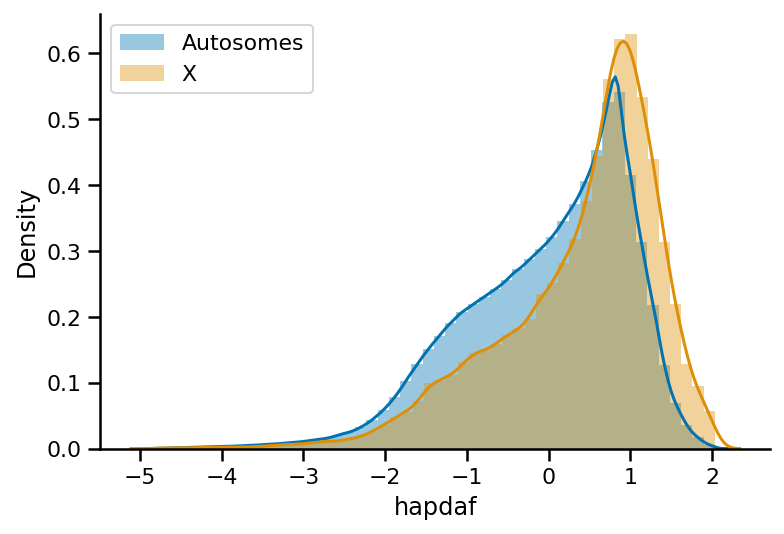

In [12]:
sns.distplot(hapdaf_phys.loc[hapdaf_phys.is_autosome, 'hapdaf'], label='Autosomes') 
sns.distplot(hapdaf_phys.loc[~hapdaf_phys.is_autosome, 'hapdaf'], label='X') 
plt.legend()
sns.despine()

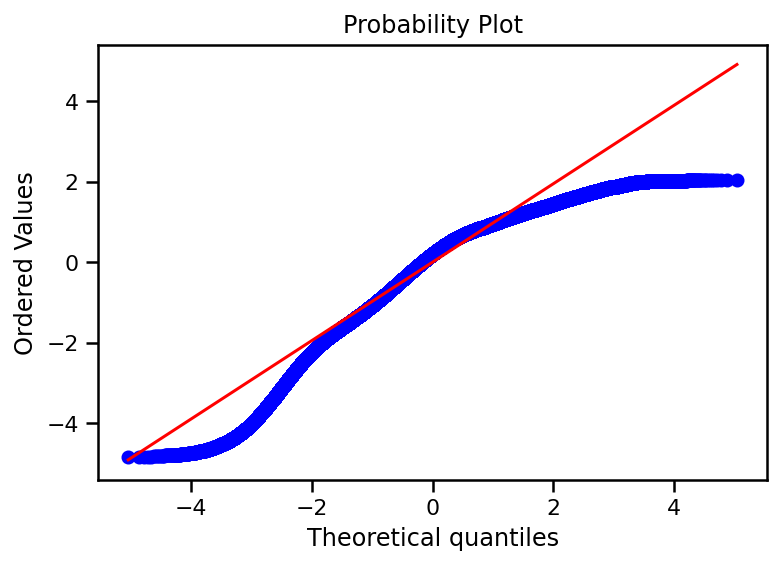

In [13]:
scipy.stats.probplot(hapdaf_phys.hapdaf, dist="norm", plot=plt) ; 

## Compute p-values

/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


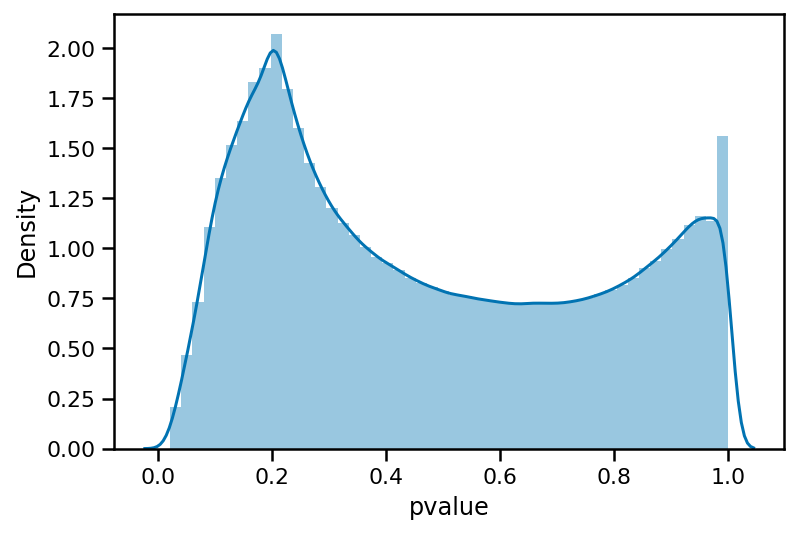

In [14]:
hapdaf_phys['pvalue'] = 1 - scipy.stats.norm.cdf(hapdaf_phys.hapdaf)
#hapdaf_phys['pvalue'] = 1 - 2 * abs(scipy.stats.norm.cdf(hapdaf_phys.hapdaf) - 0.5)
sns.distplot(hapdaf_phys.pvalue) ;

Not uniform...

In [15]:
hapdaf_phys.chrom.unique()

array(['1', '2', '3', '4', '5', '6', '7', 'X', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '20', '19', '22', '21'],
      dtype=object)

In [16]:
hapdaf_phys['logp'] = -np.log10(hapdaf_phys.pvalue)

## Number of SNPs used for each hapdaf statstic

/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


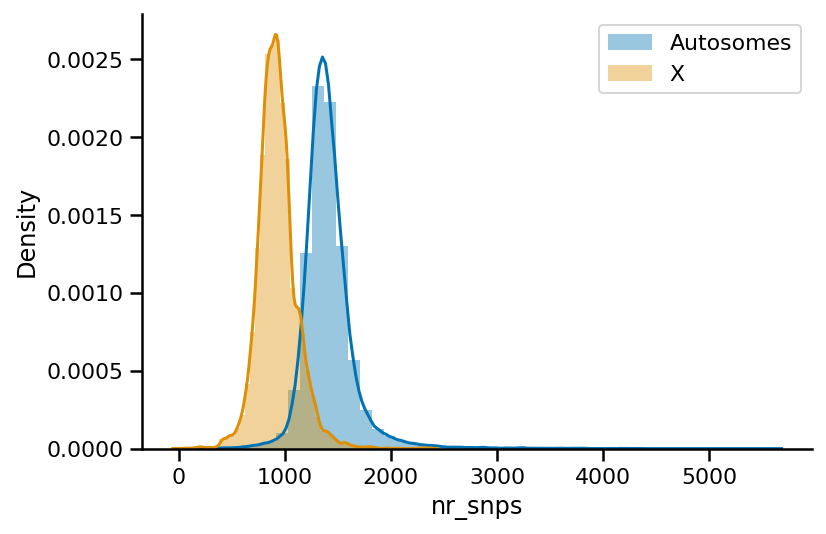

In [17]:
sns.distplot(hapdaf_phys.loc[hapdaf_phys.is_autosome, 'nr_snps'], label='Autosomes') 
sns.distplot(hapdaf_phys.loc[~hapdaf_phys.is_autosome, 'nr_snps'], label='X') 
plt.legend()
sns.despine()

Filter values based on to few SNPs:

In [18]:
hapdaf_phys = hapdaf_phys.loc[hapdaf_phys.nr_snps > 2500]

## Extended peak regions:

In [19]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

FileNotFoundError: File /home/kmt/simons/faststorage/people/kmt/results/extended_peak_regions_10%.hdf does not exist

## All p-values

Chromosome X:

In [ ]:
fig = plt.figure(figsize=(15, 5))
hapdaf_phys_chrX = hapdaf_phys.loc[hapdaf_phys.chrom == 'X']
plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.logp, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chrX.logp, hapdaf_phys_chrX.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='orange')

for tup in extended_peak_regions_10.itertuples():
    add_band(tup.start_pos, tup.end_pos)
    
mpld3.display()

## All hapdaf values

Chromosome X:

In [ ]:
fig = plt.figure(figsize=(15, 5))
hapdaf_phys_chrX = hapdaf_phys.loc[hapdaf_phys.chrom == 'X']
plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chrX.hapdaf, hapdaf_phys_chrX.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1])
mpld3.display()

Chromosome 7:

In [20]:
fig = plt.figure(figsize=(15, 5))
hapdaf_phys_chr7 = hapdaf_phys.loc[hapdaf_phys.chrom == '7']
plt.plot(hapdaf_phys_chr7.phys_pos, hapdaf_phys_chr7.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chr7.hapdaf, hapdaf_phys_chr7.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1])
mpld3.display()

/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kmt/anaconda3/envs/simons_jupyter/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AttributeError: 'XAxis' object has no attribute '_gridOnMajor'

## Means in 200kb windows

In [ ]:
@window(size=200000, fill='hg19')
def mean_hapdaf(df):
    return df.hapdaf.mean()

#     if len(df):
#         return df.hapdaf.mean()
#     else:
#         return np.nan

**X chromosome:**

Gray bars are the regions I believe are sweeps (based on my own analysis).

In [ ]:
df = hapdaf_phys.loc[(hapdaf_phys.chrom == 'X')]# & (hapdaf_phys.deriv_freq > 0.1)]# & (hapdaf_phys.deriv_freq < 0.8)]
hapdaf_phys_win_mean = df.assign(start=df.phys_pos, end=df.phys_pos).pipe(mean_hapdaf)                        

plot_df = stairs(hapdaf_phys_win_mean)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.mean_hapdaf)

for tup in extended_peak_regions_10.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)
    
mpld3.display()

**Similar sized chromosome 7:**

In [ ]:
df = hapdaf_phys.loc[hapdaf_phys.chrom == '2']
hapdaf_phys_win_mean = df.assign(start=df.phys_pos, end=df.phys_pos).pipe(mean_hapdaf)                        

plot_df = stairs(hapdaf_phys_win_mean)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.mean_hapdaf)

#plt.axvline(136545410)
add_band(136545410, 136594750)

mpld3.display()

## Min in rolling windows

In [ ]:
def rolling_window(data, size, step):

    df_list = list()
    for start in range(0, size, step):

        assert (size / step) % 2 # must be uneven
        mid_offset = (size / step) // 2 * step

        @window(size=size, start=start)
        def min_hapdaf(df):
            return df.hapdaf.min()
        offset_df = data.groupby(['chrom']).apply(min_hapdaf)


        offset_df['start'] = offset_df.start + mid_offset + start
        offset_df['end'] = offset_df.start + step

        df_list.append(offset_df)

    return pd.concat(df_list).sort_values('start')

In [ ]:
def plot_roll_min_hapdaf(df, plot_bands=False):
    
    df_roll = df.assign(start=df.phys_pos, end=df.phys_pos)

    hapdaf_phys_win_roll_min = (rolling_window(df_roll, 250000, 50000)
                                .assign(pos=lambda df: df.start + (df.end-df.start)/2)
                               )
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    plt.plot(hapdaf_phys_win_roll_min.pos, hapdaf_phys_win_roll_min.min_hapdaf, linewidth=2)
#    ax.set_ylim(-3.5, 3.5)
    if plot_bands:
        for tup in extended_peak_regions_10.itertuples():
            add_band(tup.start_pos, tup.end_pos, ax=ax)
    return fig

In [ ]:
fig = plot_roll_min_hapdaf(hapdaf_phys.loc[hapdaf_phys.chrom == 'X'], plot_bands=True)
mpld3.display(fig)

In [ ]:
def plot_roll_min_hapdaf(df, plot_bands=False):
    
    df_roll = df.assign(start=df.phys_pos, end=df.phys_pos)

    hapdaf_phys_win_roll_min = (rolling_window(df_roll, 500000, 100000)
                                .assign(pos=lambda df: df.start + (df.end-df.start)/2)
                               )
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    plt.plot(hapdaf_phys_win_roll_min.pos, hapdaf_phys_win_roll_min.min_hapdaf, linewidth=2)
#    ax.set_ylim(-3.5, 3.5)    
    if plot_bands:
        for tup in extended_peak_regions_10.itertuples():
            add_band(tup.start_pos, tup.end_pos, ax=ax)
    return fig

In [ ]:
fig = plot_roll_min_hapdaf(hapdaf_phys.loc[hapdaf_phys.chrom == 'X'], plot_bands=True)
mpld3.display(fig)

## Autosomes:

In [ ]:
fig = plot_roll_min_hapdaf(hapdaf_phys.loc[hapdaf_phys.chrom == '1'])
mpld3.display(fig)

In [ ]:
fig = plot_roll_min_hapdaf(hapdaf_phys.loc[hapdaf_phys.chrom == '2'])
add_band(136545410, 136594750, color='red', alpha=1)
mpld3.display(fig)

In [ ]:
fig = plot_roll_min_hapdaf(hapdaf_phys.loc[hapdaf_phys.chrom == '3'])
mpld3.display(fig)

## Dependency of min stat on the number of stats in each window

Make sure there is not strong correlation between min statistic and number of statistics in each window. We do not want a large min value to just reflect that there few values to pick a small value from.

In [ ]:
@window(size=500000, fill='hg19')
def roll_stats(df):
    return {'roll_min_hapdaf': df.hapdaf.min(), 'roll_nr_sites': df.hapdaf.size}

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

df = hapdaf_phys.loc[hapdaf_phys.chrom == 'X']
roll_df = df.assign(start=df.phys_pos, end=df.phys_pos).pipe(roll_stats)
ax[0].scatter(roll_df.roll_nr_sites, roll_df.roll_min_hapdaf)
ax[0].set_xlabel('Nr. hapDAF stats in rolling window')
ax[0].set_ylabel('Min hapDAF in rolling window')
ax[0].set_title('Chromosome X')

df = hapdaf_phys.loc[hapdaf_phys.chrom == '7']
roll_df = df.assign(start=df.phys_pos, end=df.phys_pos).pipe(roll_stats)
ax[1].scatter(roll_df.roll_nr_sites, roll_df.roll_min_hapdaf)
ax[1].set_xlabel('Nr. hapDAF stats in rolling window')
ax[1].set_ylabel('Min hapDAF in rolling window') ;
ax[1].set_title('Chromosome 7') ;

In [ ]:
def plot_min_hapdaf_and_SNPcount(df):
    df_roll = (df
#             .loc[lambda df: df.hapdaf > 0.25]
             .assign(start=df.phys_pos, 
                     end=df.phys_pos)
             .pipe(roll_stats)
    )
    plot_df = stairs(df_roll) 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,6), sharex=True)
    ax1.plot(plot_df.pos, plot_df.roll_min_hapdaf)
    ax2.plot(plot_df.pos, plot_df.roll_nr_sites)
    ax1.set_ylim(0.25, 2.5)
    ax1.axhline(0.5, linestyle='dashed')
    sns.despine()
    return ax1

ax = plot_min_hapdaf_and_SNPcount(hapdaf_phys.loc[hapdaf_phys.chrom == 'X'])


for tup in extended_peak_regions_10.itertuples():
    add_band(tup.start_pos, tup.end_pos, ax=ax)


## Confounded with low recombination rate

Do genetic distance instead